In [1]:
GPU = True #set to True to use GPU for XGboost and LightGBM

### Baseline Models

Simple If-Then Models

 - Home team always wins (Accuracy = 0.59, AUC = 0.50 on Train data, Accuracy = 0.49, AUC = 0.50 on Test data)

 
ML Models

 - LightGBM (Accuracy = 0.58, AUC = 0.64 on Test data)
 - XGBoost (Accuracy = 0.59, AUC = 0.61 on Test data)
    

In [2]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold

import xgboost as xgb
print('XGB version:', xgb.__version__)

import lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation
print('LGB version:', lgb.__version__)

from tqdm import tqdm

import shap

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path  #for Windows/Linux compatibility
DATAPATH = Path(r'data')


XGB version: 1.6.1
LGB version: 3.3.2


In [3]:
train = pd.read_csv(DATAPATH / "train.csv")
test = pd.read_csv(DATAPATH / "test.csv")

train.head()

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,PLAYOFF,TARGET
0,2022-03-12,22101005,1610612748,1610612750,2021,104.0,0.398,0.760,0.333,23.0,53.0,113.0,0.422,0.875,0.357,21.0,46.0,0,0,0
1,2022-03-12,22101006,1610612741,1610612739,2021,101.0,0.443,0.933,0.429,20.0,46.0,91.0,0.419,0.824,0.208,19.0,40.0,1,0,1
2,2022-03-12,22101007,1610612759,1610612754,2021,108.0,0.412,0.813,0.324,28.0,52.0,119.0,0.489,1.000,0.389,23.0,47.0,0,0,0
3,2022-03-12,22101008,1610612744,1610612749,2021,122.0,0.484,0.933,0.400,33.0,55.0,109.0,0.413,0.696,0.386,27.0,39.0,1,0,1
4,2022-03-12,22101009,1610612743,1610612761,2021,115.0,0.551,0.750,0.407,32.0,39.0,127.0,0.471,0.760,0.387,28.0,50.0,0,0,0


**Model - Home team always wins**

In [4]:
# train data

predict = predict = np.ones((train.shape[0],))
true =  train['TARGET']

accuracy_score(true,predict), roc_auc_score(true,predict)

(0.5901639344262295, 0.5)

In [5]:
# test data

predict = predict = np.ones((test.shape[0],))
true =  test['TARGET']

accuracy_score(true,predict), roc_auc_score(true,predict)

(0.4851085310449268, 0.5)

### ML Baseline Models

**Fix Datatypes for smaller memory footprint**

In [6]:
def fix_datatypes(df):
    df['GAME_DATE_EST'] = pd.to_datetime(df['GAME_DATE_EST'])

    long_integer_fields = ['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON']

    #convert long integer fields to int32 from int64
    for field in long_integer_fields:
        df[field] = df[field].astype('int32')
    
    #convert the remaining int64s to int8
    for field in df.select_dtypes(include=['int64']).columns.tolist():
        df[field] = df[field].astype('int8')
        
    #convert float64s to float16s
    for field in df.select_dtypes(include=['float64']).columns.tolist():
        df[field] = df[field].astype('float16')
        
    return df

train = fix_datatypes(train)
test = fix_datatypes(test)


**Basic Feature Engineering**

Because the basic data is post-game data, there would be data leakage if we used the data as is. We need to create features that are available before the game starts. Namely, we will do a rolling average for each stat for the last 5 games.

In [7]:
def add_rolling_means(df, location):
    
    location_id = location + "_TEAM_ID"

    # sort games by the order in which they were played for each home or visitor team
    df = df.sort_values(by = [location_id, 'GAME_DATE_EST'], axis=0, ascending=[True, True,], ignore_index=True)
    
    # rolling means
    feature_list = ['HOME_TEAM_WINS', 'PTS_home', 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home']
    
    if location == 'VISITOR':
        feature_list = ['HOME_TEAM_WINS', 'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away']

    roll_feature_list = []
    for feature in feature_list:
        roll_feature_name = location + '_' + feature + '_AVG_LAST_' + '5_' + location
        if feature == 'HOME_TEAM_WINS': #remove the "HOME_" for better readability
            roll_feature_name = location + '_' + feature[5:] + '_AVG_LAST_' + '5_' + location
        roll_feature_list.append(roll_feature_name)
        df[roll_feature_name] = df.groupby(['HOME_TEAM_ID'])[feature].rolling(5, closed= "left").mean().values

    return df

train = add_rolling_means(train, 'HOME')
train = add_rolling_means(train, 'VISITOR')
test = add_rolling_means(test, 'HOME')
test = add_rolling_means(test, 'VISITOR')

train

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,PLAYOFF,TARGET,HOME_TEAM_WINS_AVG_LAST_5_HOME,HOME_PTS_home_AVG_LAST_5_HOME,HOME_FG_PCT_home_AVG_LAST_5_HOME,HOME_FT_PCT_home_AVG_LAST_5_HOME,HOME_FG3_PCT_home_AVG_LAST_5_HOME,HOME_AST_home_AVG_LAST_5_HOME,HOME_REB_home_AVG_LAST_5_HOME,VISITOR_TEAM_WINS_AVG_LAST_5_VISITOR,VISITOR_PTS_away_AVG_LAST_5_VISITOR,VISITOR_FG_PCT_away_AVG_LAST_5_VISITOR,VISITOR_FT_PCT_away_AVG_LAST_5_VISITOR,VISITOR_FG3_PCT_away_AVG_LAST_5_VISITOR,VISITOR_AST_away_AVG_LAST_5_VISITOR,VISITOR_REB_away_AVG_LAST_5_VISITOR
0,2003-10-29,20300006,1610612740,1610612737,2003,88.0,0.323975,0.700195,0.160034,24.0,55.0,83.0,0.397949,0.736816,0.213989,18.0,58.0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003-10-31,20300024,1610612741,1610612737,2003,100.0,0.399902,0.758789,0.500000,27.0,53.0,94.0,0.399902,0.713867,0.583008,22.0,48.0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003-11-05,20300060,1610612744,1610612737,2003,99.0,0.446045,0.645020,0.278076,23.0,52.0,72.0,0.366943,0.500000,0.333008,19.0,43.0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003-11-08,20300084,1610612757,1610612737,2003,90.0,0.425049,0.899902,0.500000,28.0,41.0,83.0,0.437988,0.786133,0.099976,21.0,45.0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003-11-09,20300089,1610612760,1610612737,2003,81.0,0.378906,0.736816,0.056000,12.0,46.0,91.0,0.479004,0.789062,0.533203,16.0,41.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24273,2022-03-23,22101084,1610612752,1610612766,2021,121.0,51.812500,88.187500,44.406250,30.0,40.0,106.0,47.187500,52.906250,28.296875,26.0,45.0,1,0,1,0.0,109.0,9.739795,17.749121,7.852295,23.4,46.4,1.0,94.8,0.444971,0.728418,0.283203,22.6,46.0
24274,2022-03-25,22101100,1610612762,1610612766,2021,101.0,45.187500,72.687500,36.187500,25.0,38.0,107.0,46.593750,70.625000,38.187500,26.0,45.0,0,0,0,0.6,113.6,26.277930,50.629980,19.173877,19.8,44.0,1.0,99.6,0.461768,0.723437,0.316211,23.0,43.8
24275,2022-03-28,22101122,1610612743,1610612766,2021,113.0,46.500000,75.000000,36.406250,29.0,51.0,109.0,47.312500,66.687500,31.000000,33.0,40.0,1,0,1,0.4,114.8,31.149805,47.906152,22.167212,29.0,44.4,1.0,100.4,0.452393,0.737891,0.336987,23.8,45.6
24276,2022-04-07,22101196,1610612753,1610612766,2021,101.0,40.000000,76.875000,31.296875,27.0,43.0,128.0,52.187500,74.125000,35.312500,29.0,56.0,0,0,0,0.2,106.0,25.906494,44.651953,18.659521,24.8,46.8,1.0,97.8,0.436377,0.733887,0.330786,24.6,44.4


**Select Features**

In [8]:
target = train['TARGET']
test_target = test['TARGET']

category_columns = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'HOME_TEAM_WINS', 'PLAYOFF', 'CONFERENCE_x', 'CONFERENCE_y',]

all_columns = train.columns.tolist()
drop_columns = ['TARGET', 'GAME_DATE_EST', 'GAME_ID',] #not really useful as-is

# non-rolling features, which would be data leakage
drop_columns1 = ['HOME_TEAM_WINS', 'PTS_home', 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home']
drop_columns2 = ['PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away']

drop_columns = drop_columns + drop_columns1
drop_columns = drop_columns + drop_columns2 

use_columns = [item for item in all_columns if item not in drop_columns]

train = train[use_columns]
test = test[use_columns]

**Options**

In [9]:
K_FOLDS = 5
SEED = 13

### LightGBM


In [10]:
%%time

NUM_BOOST_ROUND = 700
EARLY_STOPPING = 200
LOG_EVALUATION = 100

train_oof = np.zeros((train.shape[0],))
test_preds = 0
train_oof_shap = np.zeros((train.shape[0],train.shape[1]+1))
#train_oof_shap_interact = np.zeros((train.shape[0],train.shape[1]+1,train.shape[1]+1))
test_preds_shap = 0

lgb_params= {
            'seed': SEED,
            'verbose': 0,           
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc', 
            #'num_leaves': 31,
            #'learning_rate': 0.05,
            #'feature_fraction': 0.9,
            #'bagging_fraction': 0.8,
            #'bagging_freq': 5,

            }

gpu_params= {
            'device': 'gpu',
            'gpu_platform_id': 0,
            'gpu_device_id': 0,
             }

if GPU:
    lgb_params = lgb_params | gpu_params
    

# K-fold cross validation

kf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(train, target))):
    
    train_df, val_df = train.iloc[train_ind], train.iloc[val_ind]
    train_target, val_target = target[train_ind], target[val_ind]

    train_lgbdataset = lgb.Dataset(train_df, label=train_target,)
    val_lgbdataset = lgb.Dataset(val_df, label=val_target, reference = train_lgbdataset )

    model =  lgb.train(lgb_params, 
                       train_lgbdataset,
                       valid_sets=val_lgbdataset,
                       num_boost_round = NUM_BOOST_ROUND,
                       callbacks=[log_evaluation(LOG_EVALUATION),early_stopping(EARLY_STOPPING,verbose=False)],
                       #verbose_eval= VERBOSE_EVAL,
                      )

    temp_oof = model.predict(val_df)
    temp_oof_shap = model.predict(val_df, pred_contrib=True)
    
    temp_test = model.predict(test)
    temp_test_shap = model.predict(test, pred_contrib=True)

    train_oof[val_ind] = temp_oof
    test_preds += temp_test/K_FOLDS

    train_oof_shap[val_ind, :] = temp_oof_shap
    test_preds_shap += temp_test_shap/K_FOLDS
    

    #for accuracy score, prediction probabilities must be convert to binary scores (Win or Lose)
    #determine optimum threshold for conveting probablities using ROC curve
    #generally 0.5 works for balanced data
    #fpr = false positive rate, tpr = true postive rate
    fpr, tpr, thresholds = roc_curve(val_target,temp_oof)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    temp_oof_binary = (temp_oof > optimal_threshold).astype(int)

    print(accuracy_score(val_target, temp_oof_binary), roc_auc_score(val_target, temp_oof))
    

    
# Out-of-Fold composite for train data

fpr, tpr, thresholds = roc_curve(target,train_oof)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
train_oof_binary = (train_oof > optimal_threshold).astype(int)

print()
print("Composite Train OOF CV Scores:")
print()
print("Accuracy Score:",accuracy_score(target, train_oof_binary))
print("AUC Score:", roc_auc_score(target, train_oof))
print("Optimal Threshold:", optimal_threshold)

#scores for Test data

test_preds_binary = (test_preds > optimal_threshold).astype(int)
print()
print("Test data Scores:")
print()
print("Accuracy Score:",accuracy_score(test_target, test_preds_binary))
print("AUC Score:", roc_auc_score(test_target, test_preds))





0it [00:00, ?it/s]

[100]	valid_0's auc: 0.634135
[200]	valid_0's auc: 0.632891


1it [00:01,  1.43s/it]

0.5988467874794069 0.6362472691440454
[100]	valid_0's auc: 0.634467
[200]	valid_0's auc: 0.629245


2it [00:02,  1.41s/it]

0.6155271828665568 0.6375657071119729
[100]	valid_0's auc: 0.624531
[200]	valid_0's auc: 0.622904


3it [00:04,  1.42s/it]

0.6157331136738056 0.626651576094008
[100]	valid_0's auc: 0.635663
[200]	valid_0's auc: 0.632881


4it [00:05,  1.42s/it]

0.6004119464469619 0.6373983354819472
[100]	valid_0's auc: 0.636402
[200]	valid_0's auc: 0.629322


5it [00:06,  1.38s/it]

0.6210092687950567 0.6394246976593263

Composite Train OOF CV Scores:

Accuracy Score: 0.6088639920916056
AUC Score: 0.6352787422595949
Optimal Threshold: 0.5785164543042818

Test data Scores:

Accuracy Score: 0.5896012115093388
AUC Score: 0.6379955520189344
CPU times: total: 2min 4s
Wall time: 6.9 s


**Feature Importance via Split - the number of times a feature is used in the model**

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

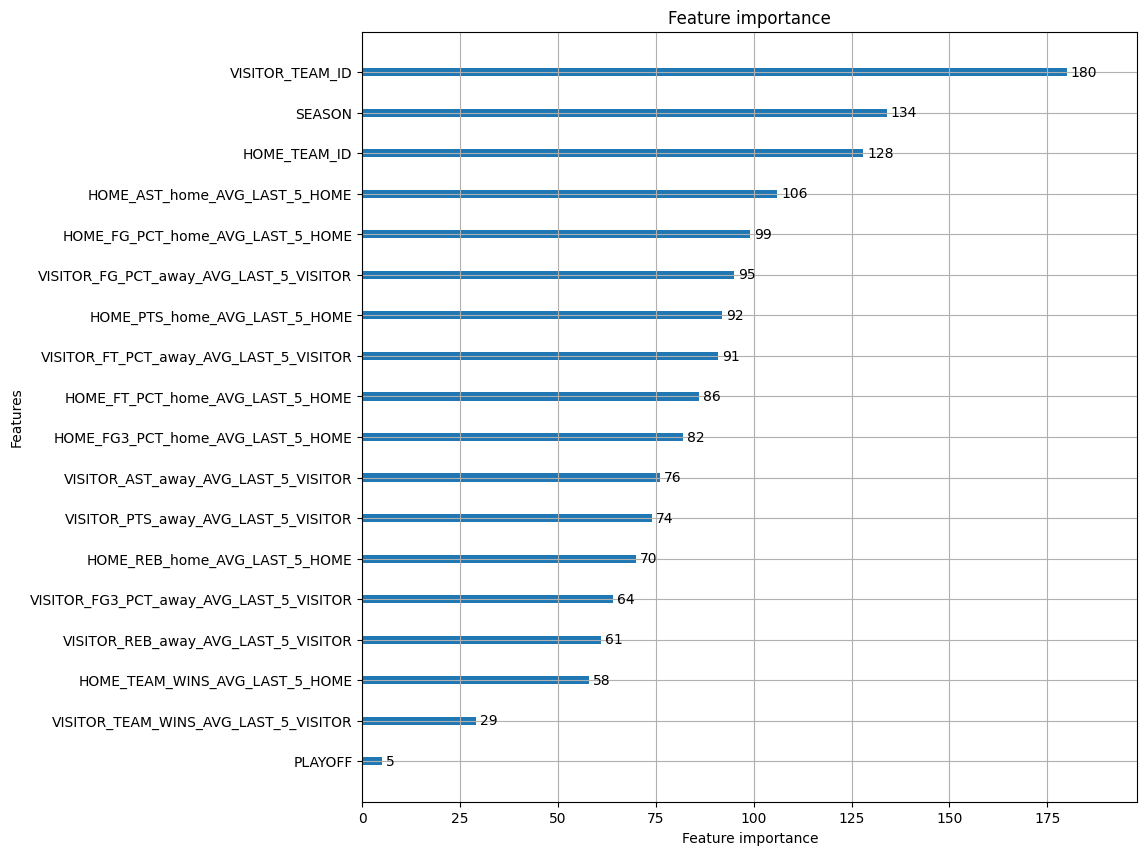

In [11]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
lgb.plot_importance(model, importance_type='split', ax=ax)

**Feature Importance via Gain - the average gain of splits which use the feature**

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

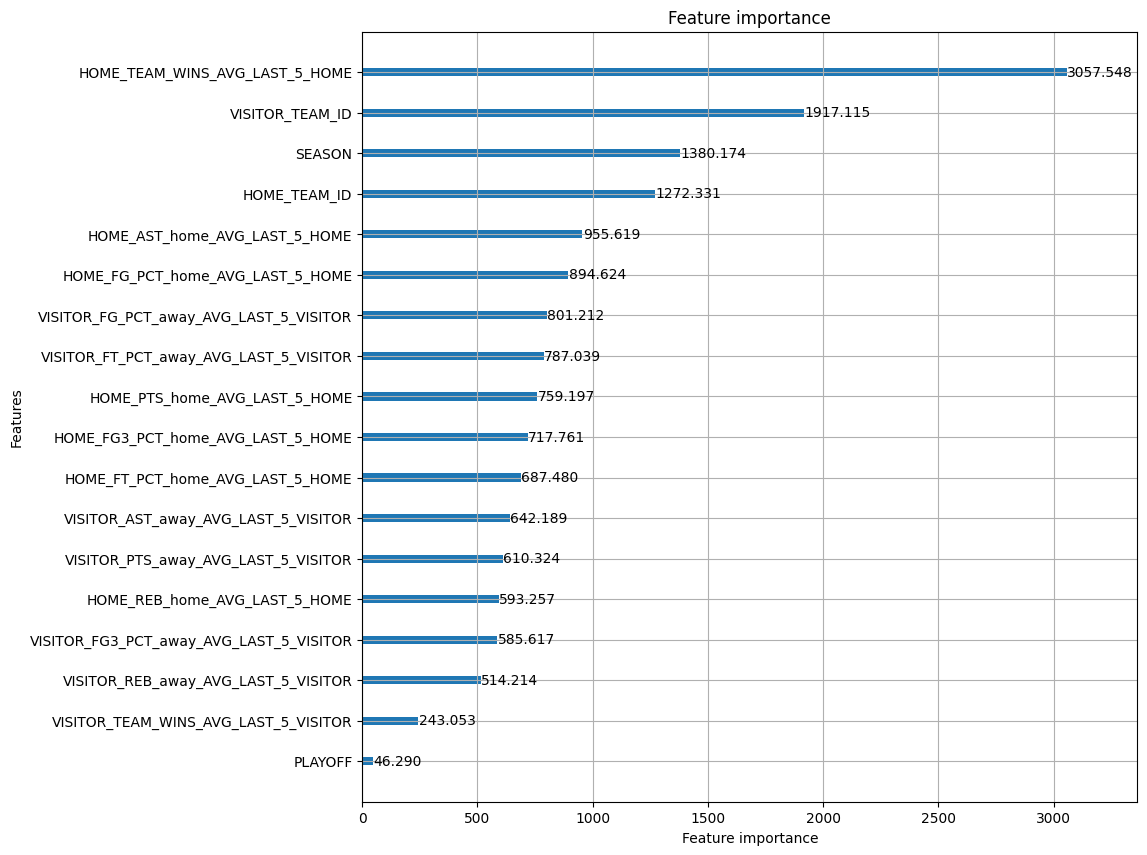

In [12]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
lgb.plot_importance(model, importance_type='gain', ax=ax)

**Feature Importance via Shapley values**

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


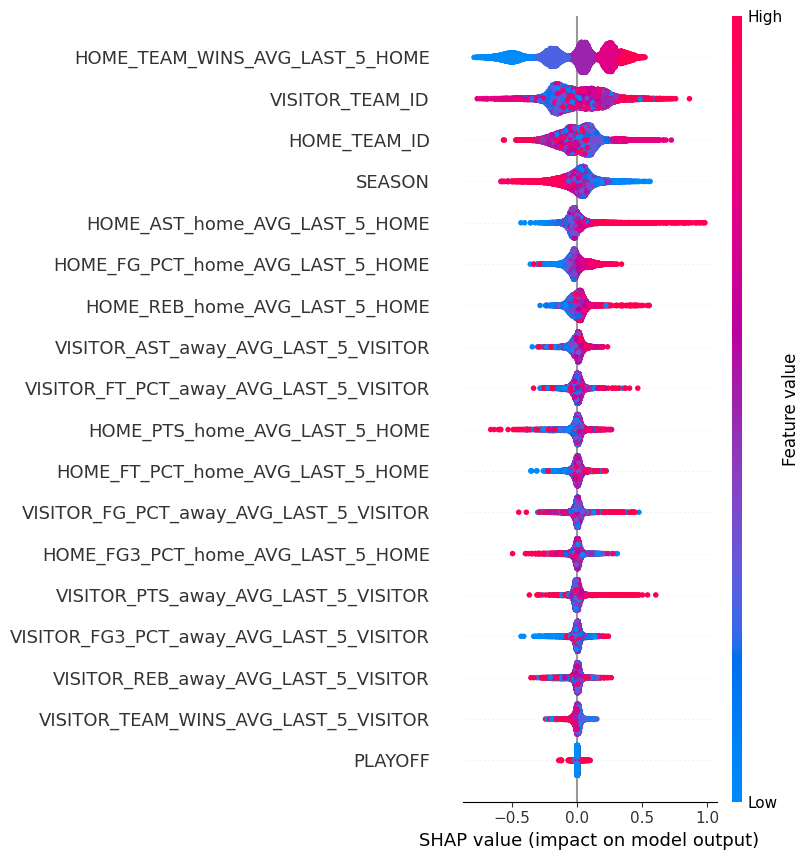

In [13]:
# summarize the effects of all the features
shap.summary_plot(train_oof_shap[:,:-1], train)

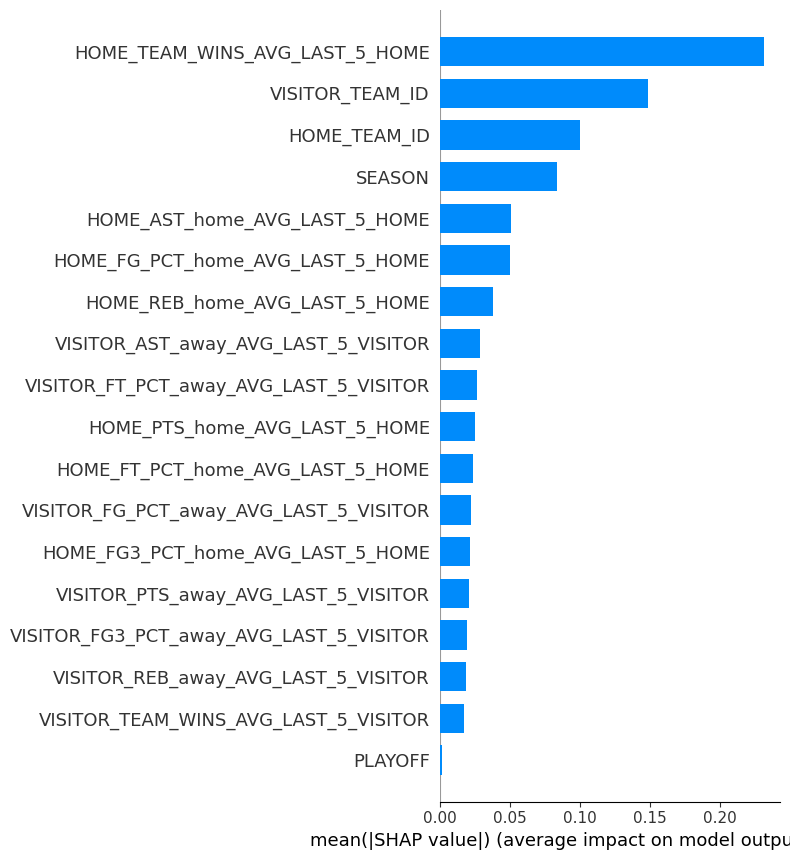

In [14]:
shap.summary_plot(train_oof_shap[:,:-1], train[use_columns], plot_type="bar")

### XGBoost


In [15]:
%%time

NUM_BOOST_ROUND = 700

train_oof = np.zeros((train.shape[0],))
test_preds = 0
train_oof_shap = np.zeros((train.shape[0],train.shape[1]+1))
train_oof_shap_interact = np.zeros((train.shape[0],train.shape[1]+1,train.shape[1]+1))
test_preds_shap = 0

xgb_params= {
            'seed': SEED,
            'eval_metric': 'auc',
             #'max_bin': 168, 
             #'max_depth': 1, #16
             #'alpha': 6.956941489832698, 
             #'gamma': 0.6029881527116713, 
             #'reg_lambda': 2.527966510426255, 
             #'colsample_bytree': 0.9087064850010729, 
             #'subsample': 0.31410604106509005, 
             #'min_child_weight': 7.877326540625619,
             #'num_parallel_tree' : 10,
             #'learning_rate': 0.03,  
            }

gpu_params= {
             'tree_method': 'gpu_hist',
             'predictor': 'gpu_predictor',
             }

if GPU:
    xgb_params = xgb_params | gpu_params
    

# K-fold cross validation

test_dmatrix = xgb.DMatrix(test)

kf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(train, target))):
    
    train_df, val_df = train.iloc[train_ind], train.iloc[val_ind]
    train_target, val_target = target[train_ind], target[val_ind]

    train_dmatrix = xgb.DMatrix(train_df, label=train_target)
    val_dmatrix = xgb.DMatrix(val_df, label=val_target)

    model =  xgb.train(xgb_params, 
                       train_dmatrix, 
                       num_boost_round = NUM_BOOST_ROUND,
                      )

    temp_oof = model.predict(val_dmatrix)
    temp_oof_shap = model.predict(val_dmatrix, pred_contribs=True)
    temp_oof_shap_interact = model.predict(val_dmatrix, pred_interactions=True)
    
    temp_test = model.predict(test_dmatrix)
    temp_test_shap = model.predict(test_dmatrix, pred_contribs=True)

    train_oof[val_ind] = temp_oof
    test_preds += temp_test/K_FOLDS

    train_oof_shap[val_ind, :] = temp_oof_shap
    train_oof_shap_interact[val_ind, :,:] = temp_oof_shap_interact
    test_preds_shap += temp_test_shap/K_FOLDS
    
    #for accuracy score, prediction probabilities must be convert to binary scores (Win or Lose)
    #determine optimum threshold for conveting probablities using ROC curve
    #generally 0.5 works for balanced data
    #fpr = false positive rate, tpr = true postive rate
    fpr, tpr, thresholds = roc_curve(val_target,temp_oof)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    temp_oof_binary = (temp_oof > optimal_threshold).astype(int)

    print(accuracy_score(val_target, temp_oof_binary), roc_auc_score(val_target, temp_oof))
    

    
# Out-of-Fold composite for train data

fpr, tpr, thresholds = roc_curve(target,train_oof)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
train_oof_binary = (train_oof > optimal_threshold).astype(int)

print()
print("Composite Train OOF CV Scores:")
print()
print("Accuracy Score:",accuracy_score(target, train_oof_binary))
print("AUC Score:", roc_auc_score(target, train_oof))
print("Optimal Threshold:", optimal_threshold)

#scores for Test data

test_preds_binary = (test_preds > optimal_threshold).astype(int)
print()
print("Test data Scores:")
print()
print("Accuracy Score:",accuracy_score(test_target, test_preds_binary))
print("AUC Score:", roc_auc_score(test_target, test_preds))



1it [00:05,  5.48s/it]

0.5102965403624382 0.5550645761957028


2it [00:10,  5.31s/it]

0.5866968698517299 0.5383407792626776


3it [00:15,  5.28s/it]

0.5759884678747941 0.5464277072732819


4it [00:21,  5.26s/it]

0.533058702368692 0.5341999701825006


5it [00:26,  5.29s/it]

0.5721936148300721 0.5499736027432099

Composite Train OOF CV Scores:

Accuracy Score: 0.5526402504324903
AUC Score: 0.5448156436846432
Optimal Threshold: 0.523716390132904

Test data Scores:

Accuracy Score: 0.5850580514891469
AUC Score: 0.6080257493215808
CPU times: total: 33.7 s
Wall time: 26.5 s


**Feature Importance via Weight - the number of times a feature appears in a tree**

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

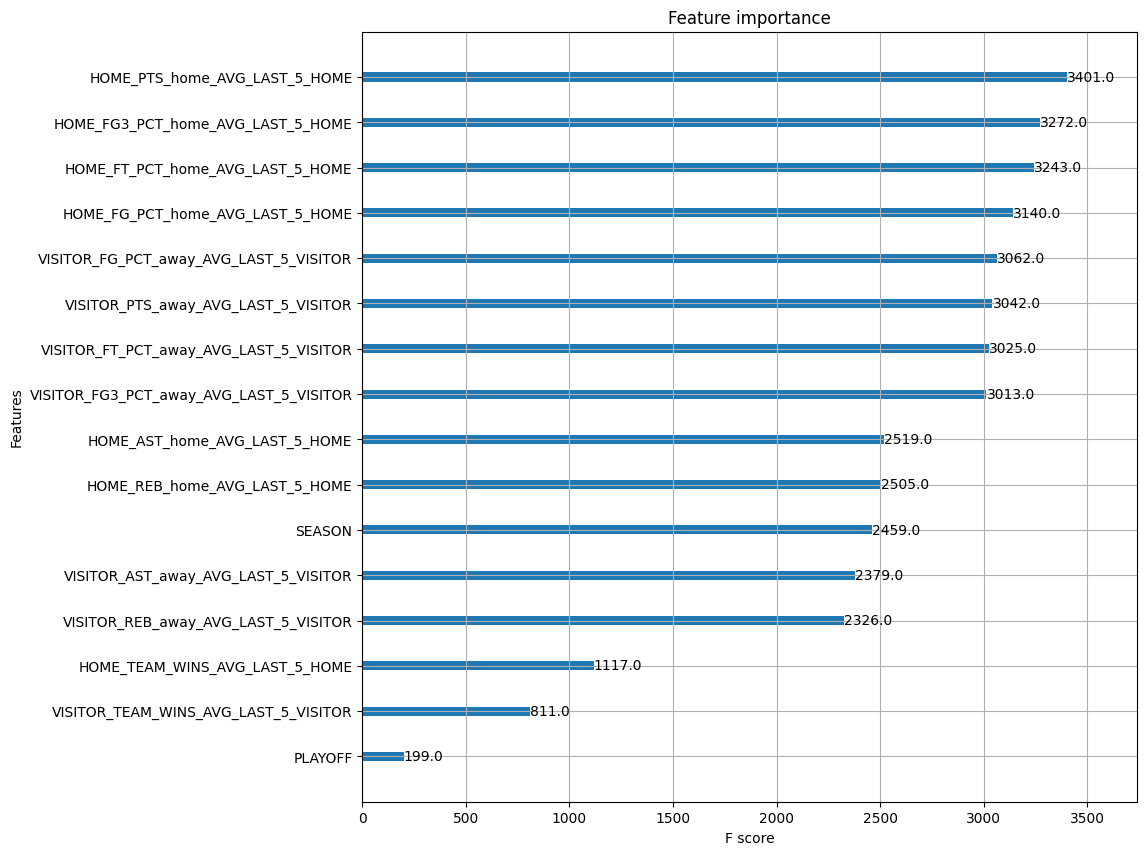

In [16]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(model, importance_type='weight', ax=ax)

**Feature Importance via Gain - the average gain of splits which use the feature**

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

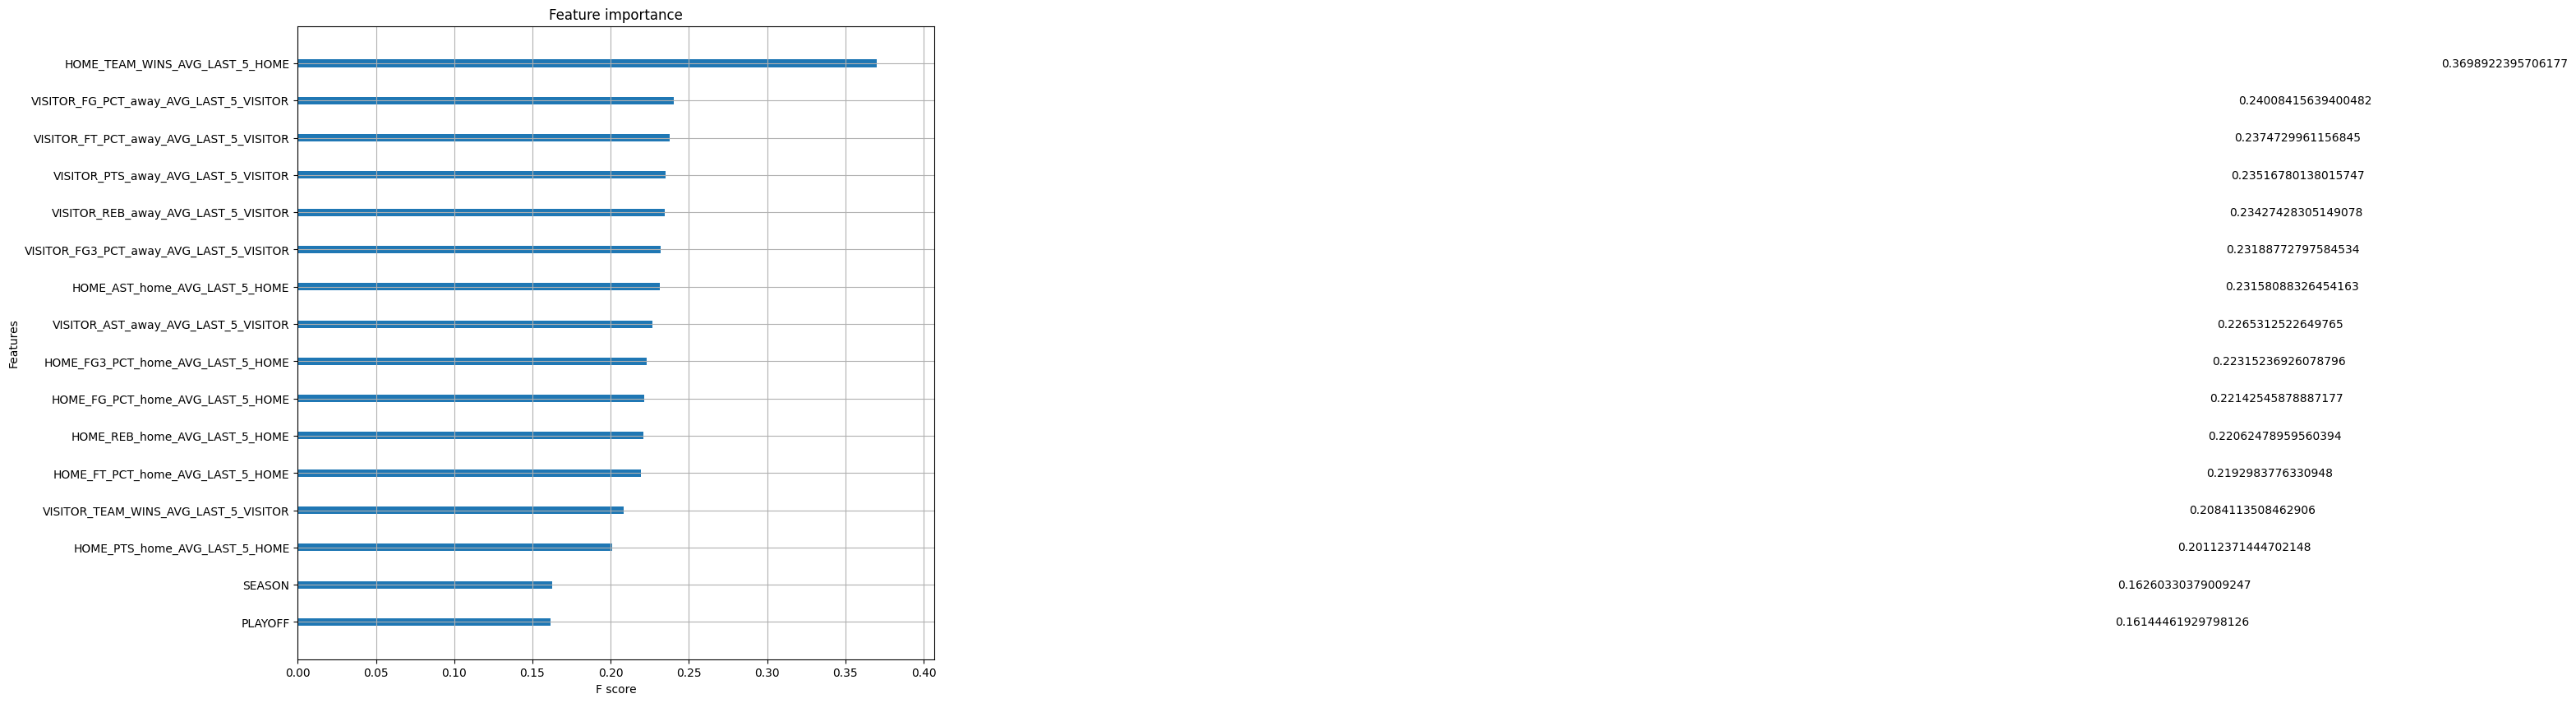

In [17]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(model, importance_type='gain', ax=ax)

**Feature Importance via Shapley values**

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


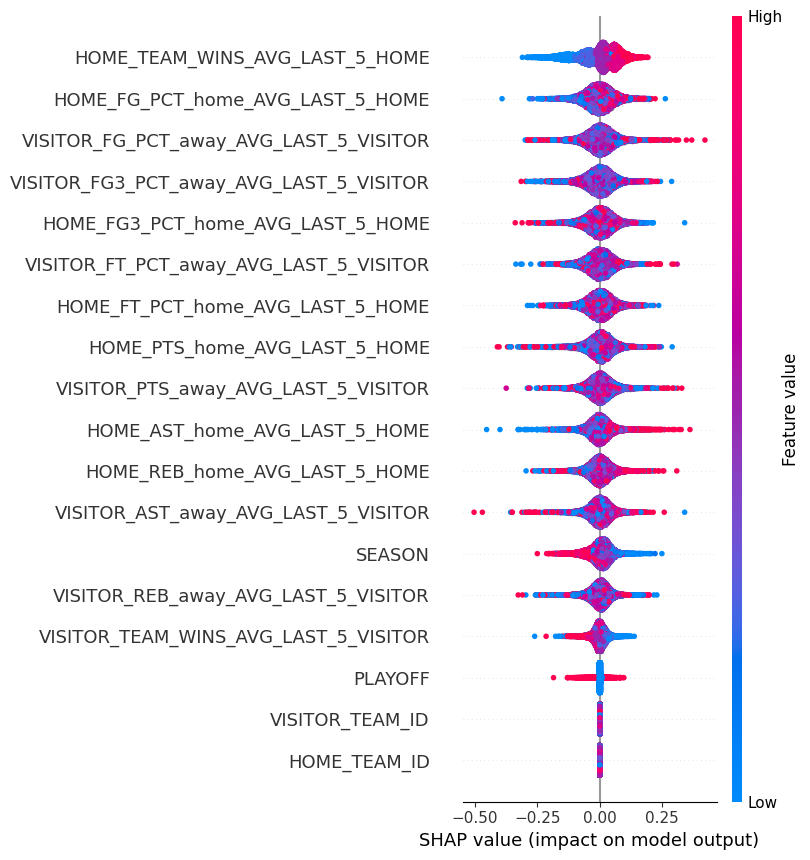

In [18]:
# summarize the effects of all the features
shap.summary_plot(train_oof_shap[:,:-1], train)

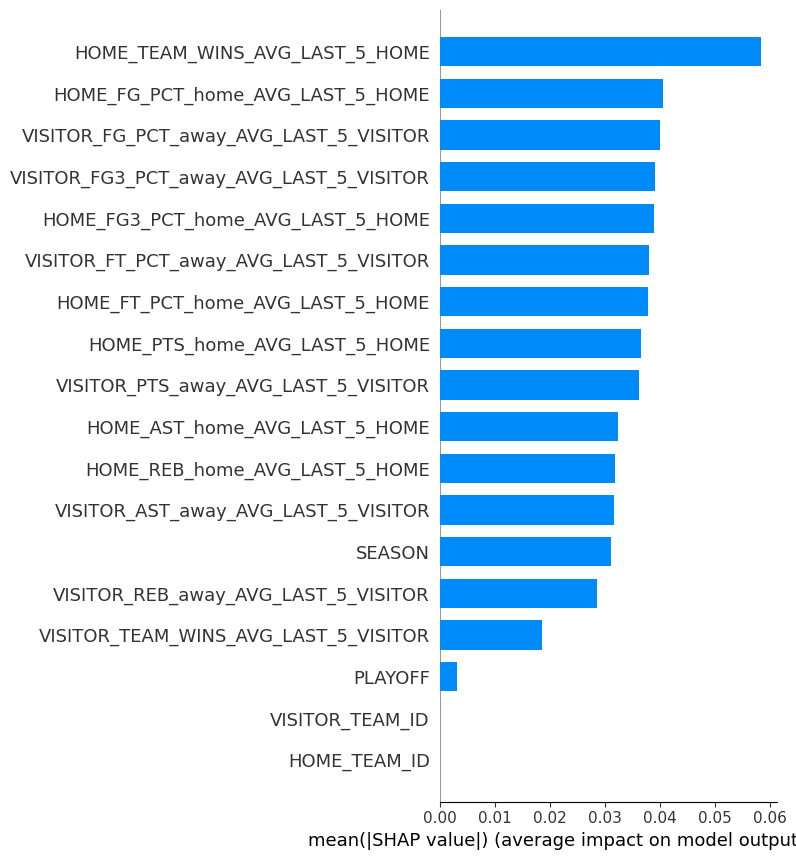

In [19]:
shap.summary_plot(train_oof_shap[:,:-1], train[use_columns], plot_type="bar")